In [43]:
#IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sklearn
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path = '/content/drive/My Drive/Colab Notebooks/COMP551_MP1/'

#read in both raw uncleaned datasets
raw_search_trends_df = pd.read_csv(path + '2020_US_weekly_symptoms_dataset.csv')
raw_hospitalization_df = pd.read_csv(path + 'aggregated_cc_by.csv')

#REMOVE ALL LOCATIONS NOT PRESENT IN BOTH DATASETS
st_location_set = set(raw_search_trends_df['open_covid_region_code'].tolist()) 
#print(st_location_set)
hos_loc_filt_df = raw_hospitalization_df[raw_hospitalization_df['open_covid_region_code'].isin(st_location_set)]
hos_loc_filt_df = hos_loc_filt_df.dropna(axis=1, how='all') # drops the columns with all null values
#hos_loc_filt_df.to_csv("hos_loc_filt.csv", index=False)

#MAKE THE DAILY DATA WEEKLY DATA TO MATCH THE SEARCH TREND DATA 
hos_loc_filt_df['date'] = pd.to_datetime(hos_loc_filt_df['date']) - pd.to_timedelta(7, unit='d')
hos_week_loc_new_filt_df = hos_loc_filt_df.groupby(['open_covid_region_code', pd.Grouper(key='date', freq='W-MON')])['hospitalized_new'].sum().reset_index().sort_values(['open_covid_region_code','date'], ascending=[True, True])
# hos_week_loc_new_filt_df.to_csv("hos_week_loc_new_filt.csv", index=False)
# if we want cumulative hospitalization data, we need to calcualte it manually using the new hospitalization data. Easy to do.
hos_week_loc_new_filt_df['hospitalized_cumulative'] = 0
cum_hos_sum = 0
prev_loc = 'US-AK'
for index, row in hos_week_loc_new_filt_df.iterrows():
    region = row['open_covid_region_code']
    cases = row['hospitalized_new']
    #two cases
    #1 region is the same, so add to cumulative, set value in df
    if region == prev_loc:
        cum_hos_sum = cum_hos_sum + cases
        hos_week_loc_new_filt_df.loc[index, 'hospitalized_cumulative'] = cum_hos_sum
    #2 region is different, reset cumulative,  set value in df
    elif region != prev_loc:
        cum_hos_sum = 0
        cum_hos_sum = cum_hos_sum + cases
        hos_week_loc_new_filt_df.loc[index, 'hospitalized_cumulative'] = cum_hos_sum
    prev_loc = region

#CLEANUP SEARCH TRENDS DATA COLUMNS BEFORE MERGE
raw_search_trends_df['date'] = pd.to_datetime(raw_search_trends_df['date']) - pd.to_timedelta(7, unit='d')
st_cleaned_data = raw_search_trends_df.dropna(axis=1, how='all') #drops any columns that are entirely null values
# st_cleaned_data = raw_search_trends_df.dropna(thresh=0.7*len(raw_search_trends_df) ,axis=1) #drops any columns with more than 70% data as nan if we wanted to
st_cleaned_data = st_cleaned_data.drop(['country_region_code', 'country_region', 'sub_region_1_code', 'sub_region_1'], axis=1)
# st_cleaned_data.to_csv("st_cleaned_data.csv", index=False)

#JOIN THE DATAFRAMES TOGETHER
st_cleaned_data = st_cleaned_data.set_index(['open_covid_region_code', 'date'])
hos_week_loc_new_filt_df = hos_week_loc_new_filt_df.set_index(['open_covid_region_code', 'date'])

combined_df = st_cleaned_data.join(hos_week_loc_new_filt_df, how='outer')
combined_df = combined_df.fillna(0)
combined_df.reset_index(level=['open_covid_region_code', 'date'], inplace=True)
#print(combined_df)
#combined_df.to_csv("combined.csv", index=True)

#IMPORT US POPULATION DATA TO BE ABLE TO NORMALIZE HOSPITALIZATIONS BY REGION
us_pop_df = pd.read_csv(path + 'us_pop_data.csv')
us_pop_df = us_pop_df[['State', 'Pop']] #remove all unnecessary data
state_to_region_code = raw_search_trends_df[['open_covid_region_code', 'sub_region_1']]
state_to_region_code = state_to_region_code.drop_duplicates()
state_to_region_code = state_to_region_code.rename(columns={'sub_region_1' : 'State'})
merged_region_state_pop = pd.merge(state_to_region_code, us_pop_df, on='State')
merged_region_pop = merged_region_state_pop.drop(['State'], axis=1)
region_pop_dict = dict(merged_region_pop.values.tolist())

combined_df['normalized_hospitalized_new'] = 0
per_pop_size = 100000
for index, row in combined_df.iterrows():
    new_hosp =  row['hospitalized_new']
    state = row['open_covid_region_code']
    state_pop = region_pop_dict[state]
    normalized_hosp_p100k = (new_hosp / state_pop) * per_pop_size
    combined_df.loc[index, 'normalized_hospitalized_new'] = normalized_hosp_p100k

#print(combined_df)
combined_df.to_csv(path + "combined.csv", index=False)

#good reference for doing all this stuff
#   https://stackoverflow.com/questions/12096252/use-a-list-of-values-to-select-rows-from-a-pandas-dataframe
#   https://stackoverflow.com/questions/43297589/merge-two-data-frames-based-on-common-column-values-in-pandas
#   https://stackoverflow.com/questions/45281297/group-by-week-in-pandas
#   https://towardsdatascience.com/its-time-for-you-to-understand-pandas-group-by-function-cc12f7decfb9
#   https://stackoverflow.com/questions/41815079/pandas-merge-join-two-data-frames-on-multiple-columns
#   https://stackoverflow.com/questions/16852911/how-do-i-convert-dates-in-a-pandas-data-frame-to-a-date-data-type
#   https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
#   https://stackoverflow.com/questions/40468069/merge-two-dataframes-by-index
#   https://stackoverflow.com/questions/25478528/updating-value-in-iterrow-for-pandas

# us population data from https://worldpopulationreview.com/states

Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


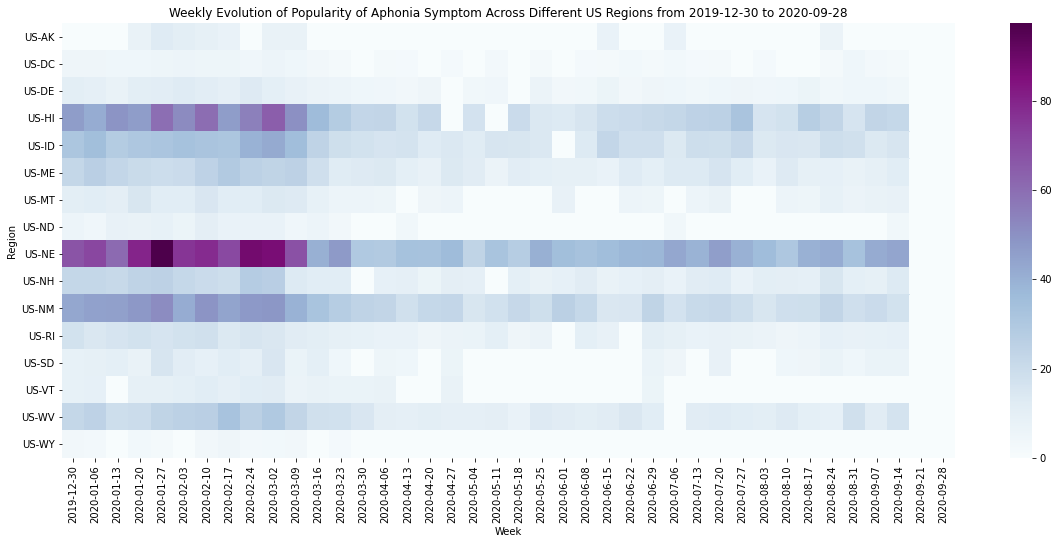

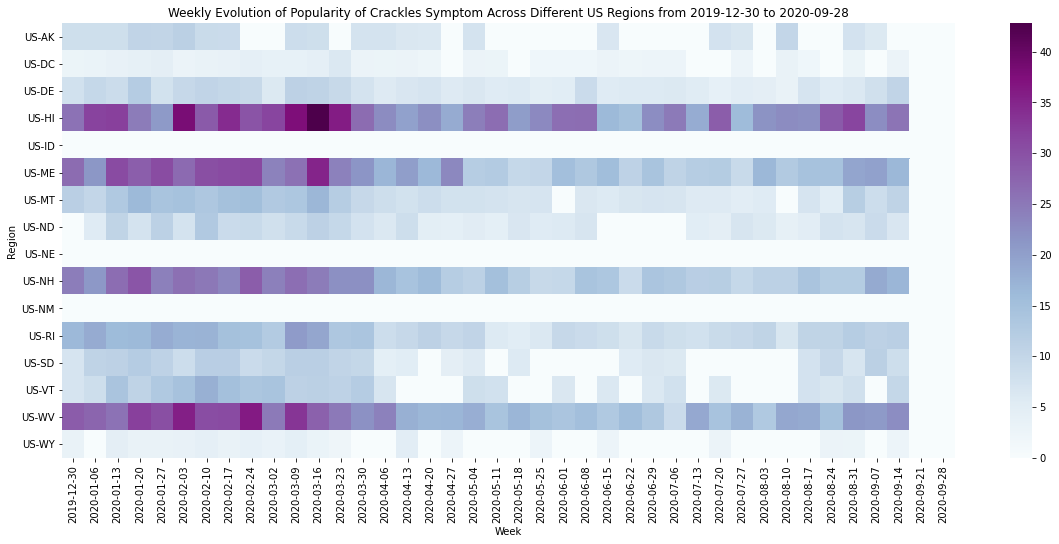

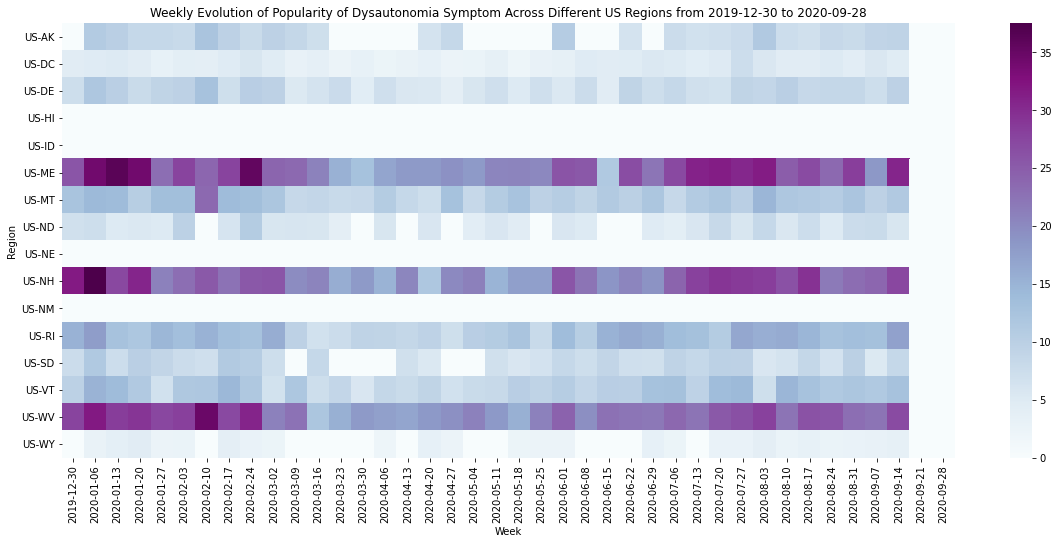

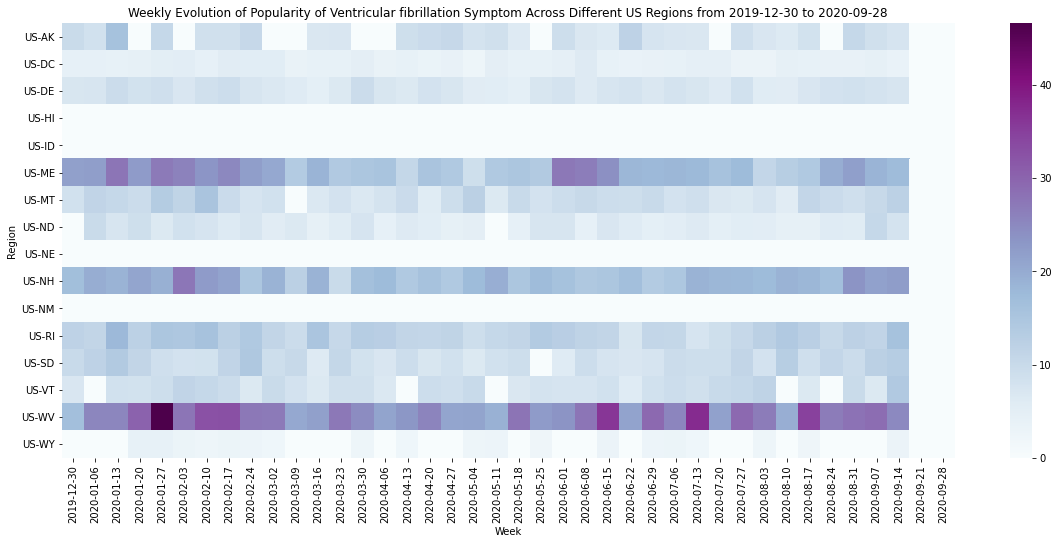

In [51]:
%matplotlib inline

df = pd.read_csv(path + 'combined.csv', skiprows=0)

df_top_symptoms = df.copy()

df_top_symptoms.drop(df_top_symptoms.columns[[0, 1, -3, -2, -1]], axis=1, inplace=True)
df_top_symptoms = df_top_symptoms.loc[:, (df_top_symptoms==0).mean() < .35]

top = []
for (columnName, columnData) in df_top_symptoms.iteritems(): 
    top.append(str(columnName))

for i in range(len(top)):
  df_plot_symptom = df.copy()
  df_plot_symptom = df_plot_symptom.pivot('open_covid_region_code', 'date', top[i])
  fig = plt.figure(figsize=(20,8))
  display_heat_map = sns.heatmap(df_plot_symptom, cmap="BuPu")
  display_heat_map.set(xlabel='Week', ylabel='Region')
  display_heat_map.set_title('Weekly Evolution of Popularity of ' + top[i].split("symptom:",1)[1]  + ' Symptom Across Different US Regions from 2019-12-30 to 2020-09-28')

plt.show()

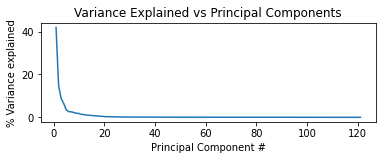

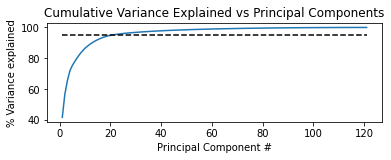

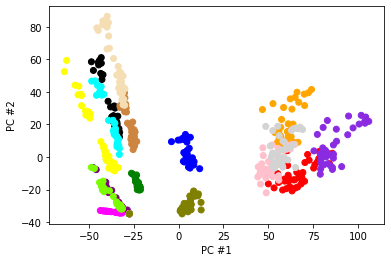

In [50]:
X = df.copy()

X.drop(X.columns[[0, 1, -3, -2, -1]], axis=1, inplace=True)
data = np.array(X)

pca = PCA()
pca.fit(data)

num_pc_components = len(pca.explained_variance_ratio_)
plt.subplot(2,1,1)
plt.plot(np.linspace(1,num_pc_components,num_pc_components),100*pca.explained_variance_ratio_)
plt.xlabel("Principal Component #")
plt.ylabel("% Variance explained")
plt.title("Variance Explained vs Principal Components")
plt.show()

plt.subplot(2,1,2)
plt.plot(np.linspace(1,num_pc_components,num_pc_components),100*np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.linspace(1,num_pc_components,num_pc_components),95*np.ones((num_pc_components,)),'k--')
plt.xlabel("Principal Component #")
plt.ylabel("% Variance explained")
plt.title("Cumulative Variance Explained vs Principal Components")
plt.show()

Y = df.copy()

target = Y.open_covid_region_code
Y.drop(Y.columns[[0, 1, -3, -2, -1]], axis=1, inplace=True)
data = np.array(Y)

pca = PCA(n_components=2)
pca.fit(data)
data_reduced = pca.transform(Y)

colors = {'US-AK':'red', 'US-DC':'green', 'US-DE':'blue', 'US-HI':'yellow', 'US-ID':'purple', 'US-ME':'black', 'US-MT':'orange', 'US-ND':'pink', 'US-NE':'magenta',
 'US-NH':'cyan', 'US-NM':'lawngreen', 'US-RI':'peru', 'US-SD':'lightgray', 'US-VT':'blueviolet', 'US-WV':'wheat', 'US-WY':'olive'}

plt.scatter(data_reduced[:,0], data_reduced[:,1], c=target.map(colors))
plt.clim(-0.5,2.5)
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.show()

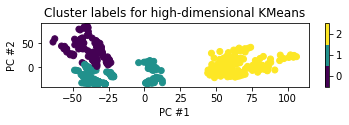

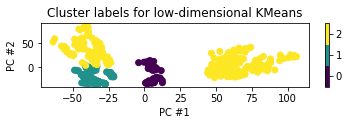

In [49]:
kmeans_high = KMeans(n_clusters=4, random_state=0)
kmeans_high.fit(data)
y_pred_high = kmeans_high.predict(data)

kmeans_low = KMeans(n_clusters=4, random_state=0)
kmeans_low.fit(data_reduced)
y_pred_low = kmeans_low.predict(data_reduced)

plt.subplot(3,1,1)
plt.scatter(data_reduced[:,0], data_reduced[:,1], c=y_pred_high, cmap=plt.cm.get_cmap('viridis',3))
plt.colorbar(ticks=[0,1,2,3])
plt.clim(-0.5,2.5)
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.title("Cluster labels for high-dimensional KMeans")
plt.show()

plt.subplot(3,1,2)
plt.scatter(data_reduced[:,0], data_reduced[:,1], c=y_pred_low, cmap=plt.cm.get_cmap('viridis',3))
plt.colorbar(ticks=[0,1,2,3])
plt.clim(-0.5,2.5)
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.title("Cluster labels for low-dimensional KMeans")
plt.show()